In [22]:

from fastai.vision import *

In [23]:
import warnings
import os
import matplotlib.pyplot as plt
import cv2

In [24]:
warnings.filterwarnings("ignore")

In [25]:
os.listdir('dataset')

['Train', 'Valid']

In [26]:
path = Path('dataset')

In [27]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [28]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 900, 225)

In [29]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 900
Number of examples in validation: 225


In [30]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

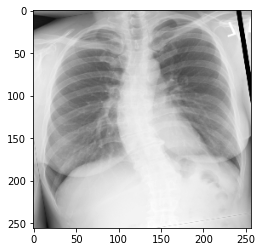

In [31]:
plt.imshow(xb[0][0],cmap='gray')

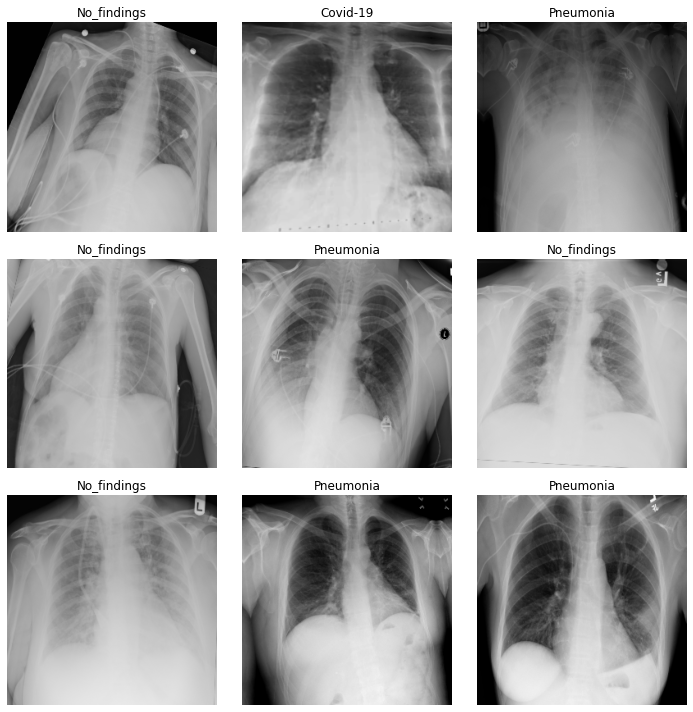

In [32]:
data.show_batch(rows=3, figsize=(10,10))

In [33]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

In [34]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [35]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [36]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [37]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [38]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [39]:
learn.fit_one_cycle(5, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.831374,1.028367,0.444444,00:58
1,0.781248,1.828575,0.533333,00:56
2,0.715946,1.661168,0.488889,00:56
3,0.652471,0.594913,0.773333,00:56
4,0.603499,0.541206,0.804444,00:57


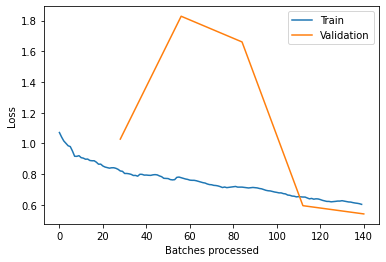

In [40]:
learn.recorder.plot_losses()

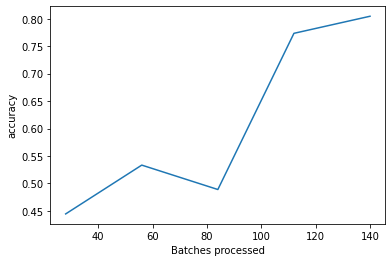

In [41]:
learn.recorder.plot_metrics()

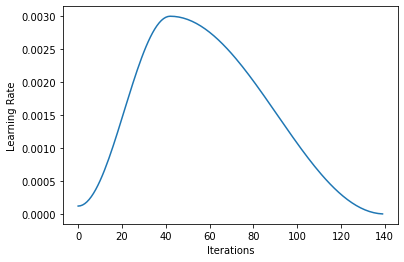

In [42]:
learn.recorder.plot_lr()